## Libraries

In [139]:
import math
import sys
import os
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
path = Path(os.path.abspath(''))
util_path = str(path.parent.absolute())

if util_path not in sys.path:
    sys.path.append(util_path)
    
from utils import helpers

In [140]:
pd.set_option('display.max_columns',None)
plt.style.use("fivethirtyeight")
np.seterr(divide = 'ignore')
warnings.filterwarnings('ignore')

## Import Data

In [4]:
def get_marketing_data():
    data = pd.read_csv("../data/raw/bank-full.csv", sep=';')
    return data

In [5]:
df = get_marketing_data()
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
print('df shape: {}'.format(df.shape))

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
for column in df.columns:
    print('Column: {} - Unique Values: {}'.format(column, df[column].unique()))

In [ ]:
df.isna().any()

## Pre-processing

In [6]:
# Pre-processing with method chaining

cols_to_category = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]
df[cols_to_category] = df[cols_to_category].astype("category")
df["y"] = np.where(df["y"] == "no", 0, 1)

## EDA

1. Visualize all the cols
2. Check for outliers
3. Random forest feature importance
4. Check target distribution
5. Check for missing values

In [134]:
target_name = 'y'
outcome_str = 'uptake'

In [190]:
from importlib import reload  # Python 3.4+
reload(helpers)

<module 'utils.helpers' from '/home/david.zhao/value-ml/utils/helpers.py'>

In [191]:
eda_helper = helpers.EDAHelper(df, target_name)

In [192]:
y_var_counts= pd.crosstab(df['marital'], df['y']).apply(lambda x: x/x.sum() *100, axis=0).assign( delta = lambda df_: df_[1] - df_[0])

for i in order:
    print(i, y_var_counts.loc[i, 'delta'])


single 8.90236717886511
married -9.17772877000489
divorced 0.27536159113978087


{'admin.': '#0f0f0f', 'blue-collar': '#0f0f0f', 'entrepreneur': '#0f0f0f', 'housemaid': '#0f0f0f', 'management': '#0f0f0f', 'retired': '#0f0f0f', 'self-employed': '#0f0f0f', 'services': '#0f0f0f', 'student': '#0f0f0f', 'technician': '#0f0f0f', 'unemployed': '#0f0f0f', 'unknown': '#0f0f0f'}


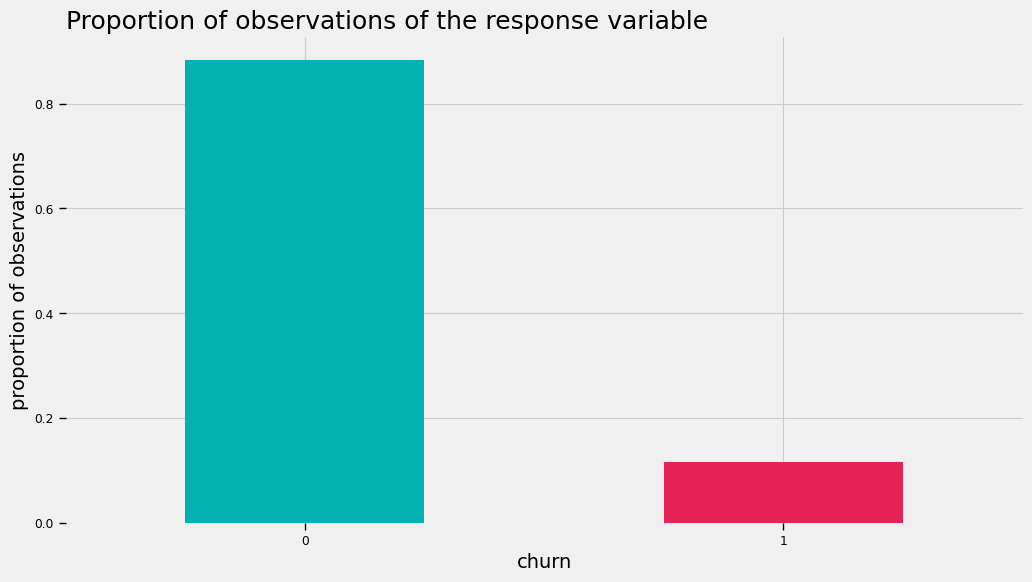

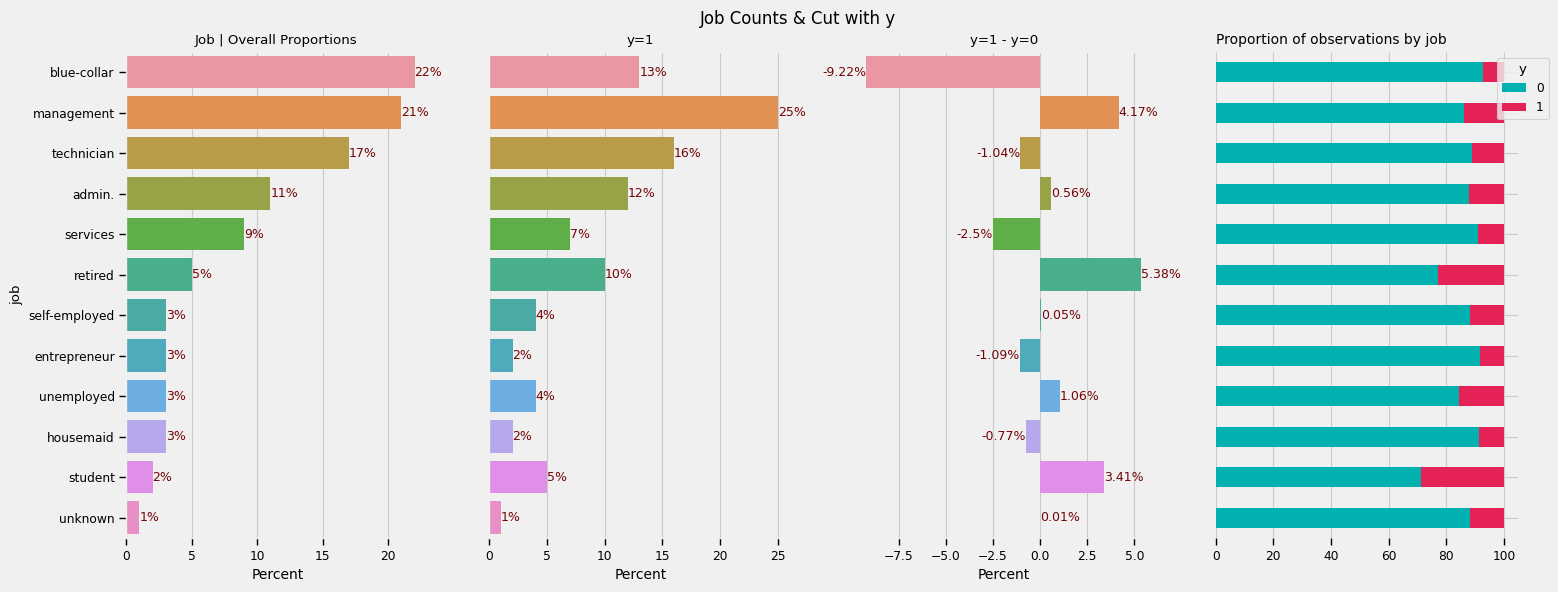

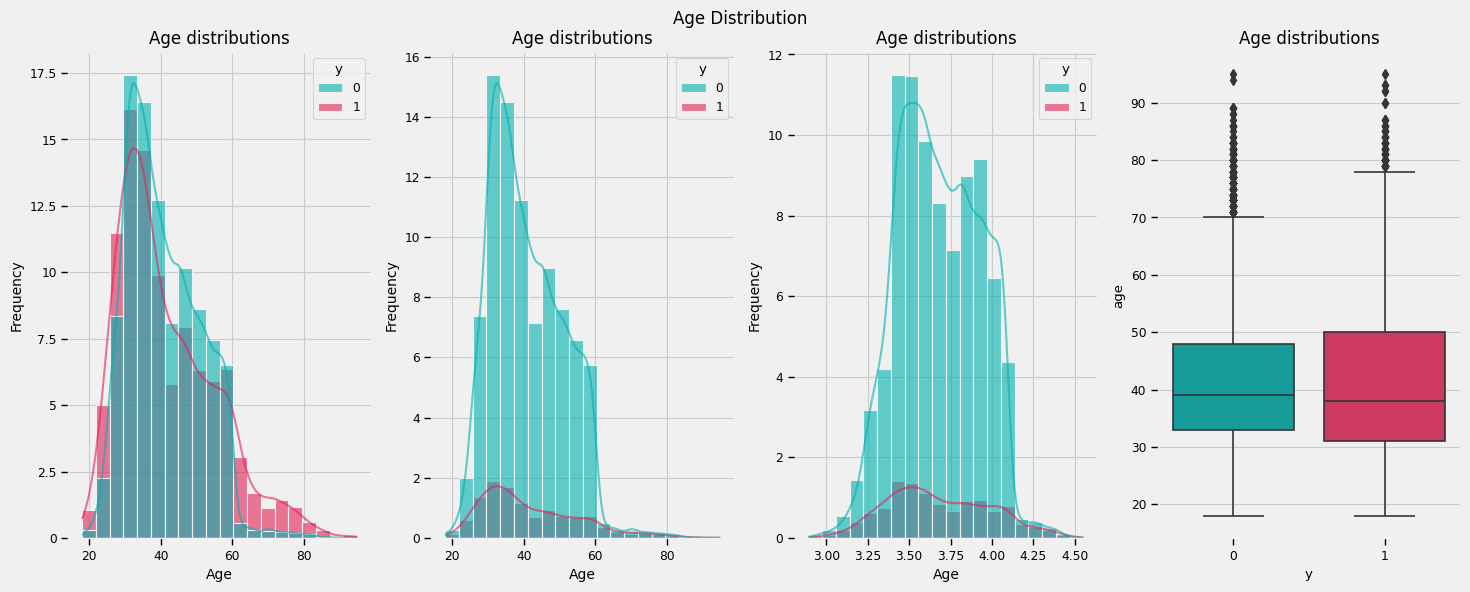

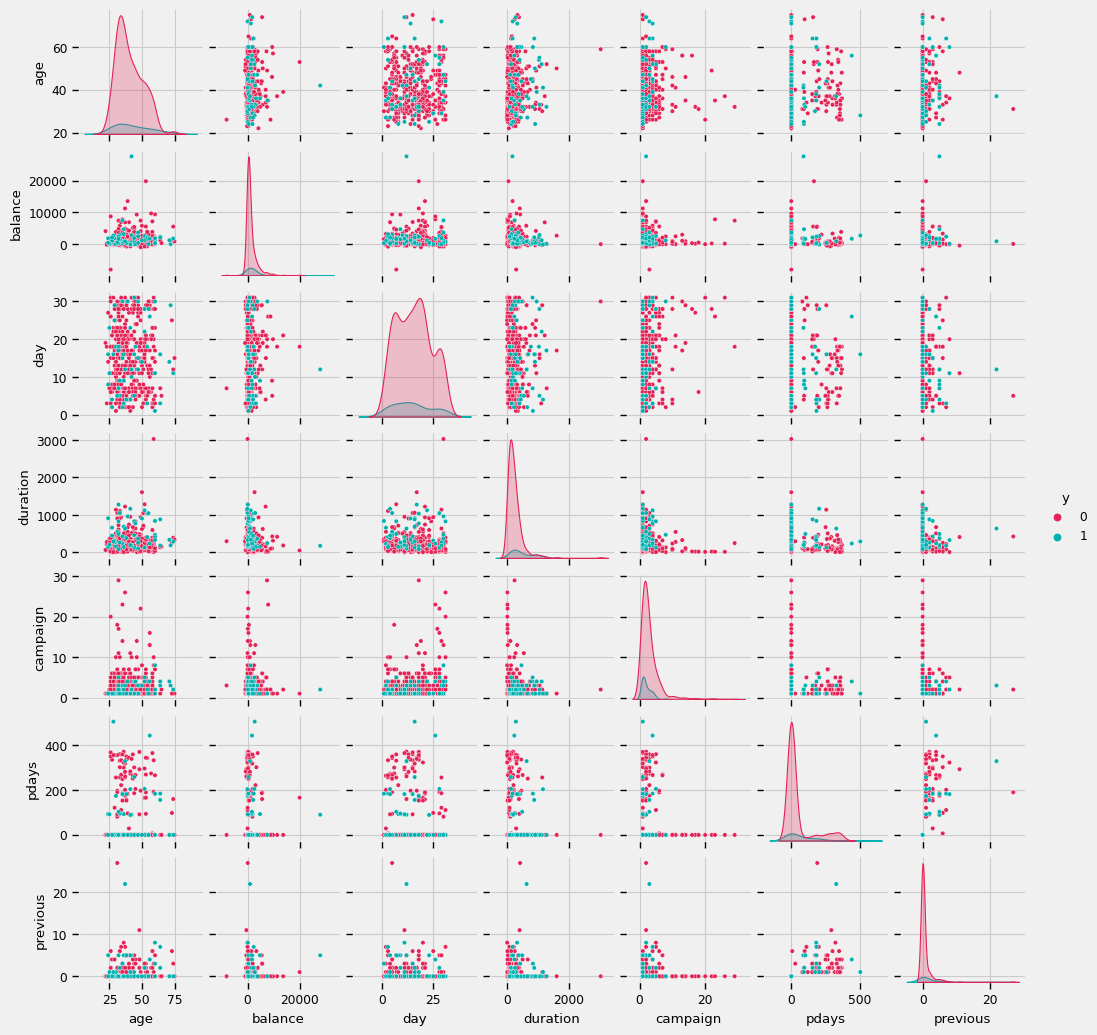

,age,balance,day,duration,campaign,pdays,previous,y
age,nan,nan,nan,nan,nan,nan,nan,nan
balance,0.10,nan,nan,nan,nan,nan,nan,nan
day,-0.01,0.00,nan,nan,nan,nan,nan,nan
duration,-0.00,0.02,-0.03,nan,nan,nan,nan,nan
campaign,0.00,-0.01,0.16,-0.08,nan,nan,nan,nan
pdays,-0.02,0.00,-0.09,-0.00,-0.09,nan,nan,nan
previous,0.00,0.02,-0.05,0.00,-0.03,0.45,nan,nan
y,0.03,0.05,-0.03,0.39,-0.07,0.10,0.09,nan


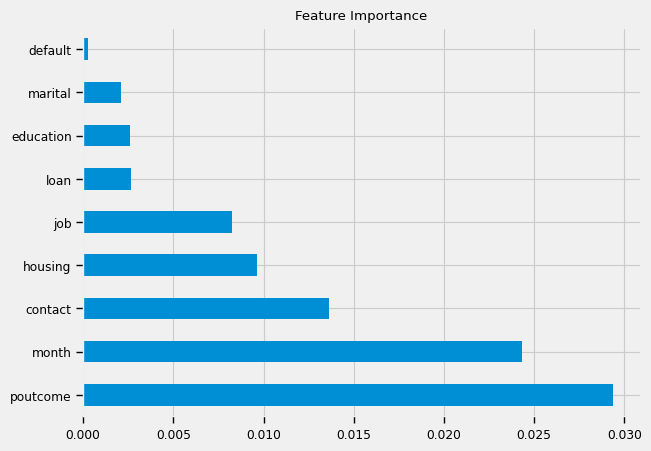

In [193]:
eda_helper.init_diagnostic()